<a href="https://colab.research.google.com/github/Sanzo00/mlc-summer22/blob/master/assignment1_zh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLC 作业 1: 端到端模型执行

## 第一部分: 模型准备

本作业的目标是让你对机器学习编译过程中的端到端模型的执行和变换更加熟悉。让我们从一个简单的图像分类模型开始。

我们首先使用如下的命令来安装必要的库。

In [1]:
!python3 -m pip install mlc-ai-nightly -f https://mlc.ai/wheels
!python3 -m pip install torch torchvision torchaudio torchsummary --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cpu


In [2]:
import numpy as np
import pickle as pkl
import torch
import torch.nn.functional as F
import torchvision
import tvm
import tvm.testing

from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms
from tvm import topi, relax, te
from tvm.script import tir as T


以下是用PyTorch定义的模型。该模型接受一批图像为输入，然后对它们依次作用卷积层，激活层，池化层和全连接层，得到分类结果。

In [3]:
batch_size = 4
input_shape = (batch_size, 1, 28, 28)  # NCHW layout


def pytorch_model():
    list = []
    list.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), bias=True))
    list.append(nn.ReLU())
    list.append(nn.MaxPool2d(kernel_size=(2, 2)))
    list.append(nn.Flatten())
    list.append(nn.Linear(in_features=5408, out_features=100, bias=True))
    list.append(nn.ReLU())
    list.append(nn.Linear(in_features=100, out_features=10, bias=True))
    list.append(nn.Softmax(dim=1))

    model = nn.Sequential(*list).cpu()
    name_map = {
        "0.weight": "conv2d_weight",
        "0.bias": "conv2d_bias",
        "4.weight": "linear0_weight",
        "4.bias": "linear0_bias",
        "6.weight": "linear1_weight",
        "6.bias": "linear1_bias",
    }
    for name, param in model.named_parameters():
        param.data = torch.from_numpy(weight_map[name_map[name]]).cpu()
    return model


我们提供了一个在Fashion MNIST数据集上的预训练权重图。

In [4]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_assignment_params.pkl

File ‘fasionmnist_mlp_assignment_params.pkl’ already there; not retrieving.



我们可以看到它的准确率约为84%。

torch.Size([1, 28, 28])


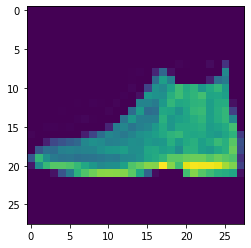

predict: Ankle boot, label: Ankle boot

Test set: Average loss: -0.8369, Accuracy: 8388/10000 (84%)



In [5]:
# Load the weight map from file.
# The prediction accuracy of the weight map on test data is around 83.3%.
weight_map = pkl.load(open("fasionmnist_mlp_assignment_params.pkl", "rb"))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        print_img = True
        for data, label in test_loader:
            data, label = data.cpu(), label.cpu()
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, label, reduction="sum").item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            if print_img:
                print(data[0].shape)
                imshow(data[0])

                print("predict: {}, label: {}".format(class_names[pred[0][0]], class_names[label[0]]))
                print_img = False
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    # npimg = np.repeat(npimg, 3, axis=0)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(npimg[0])
    plt.show()


test_data = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False)
test(pytorch_model(), test_loader)


## 第二部分: 从PyTorch迁移模型
为了展示机器学习编译对端到端模型的抽象，我们需要将模型从PyTorch迁移并转换为TVMScript实现。然后，手工迁移很难。正如你在TensorIR练习中所体验的那样，为模型中的每一层写一个元张量函数需要大量的人力来完成。另外，手工写这些函数是容易犯错的。你可以想象，当你写了几百行，但其中有零星几个bug，那么找到bug的过程将会是痛苦的。

幸运的是，在TVM中有一个简单的多的方法能够迁移模型。TVM提供了一个类`relax.BlockBuilder`，它能够从空白的IRModule开始一步步的构建端到端模型。（回忆我们在第四节课中介绍的Relax的Dataflow Block，这里的"block"就是代表了Relax函数中的Dataflow Block）

具体而言，在 `BlockBuilder`中我们有一个 `emit_te`的API，它可以将一个张量表达式（第三节课中介绍过）的算子描述转变成一个对应TensorIR函数的`call_tir`操作（`call_tir`在第四节课中介绍过）。与手工写TensorIR函数相比，写张量表达式描述可以用几行代码来完成，这减少了需要的工作量和犯错的概率。

`emit_te`的函数签名是`emit_te(func, *input)`，其中`func`是一个返回张量表达式的函数，而`*input`是`func`的输入。

让我们从一个例子开始详细介绍。在下方的代码块中，`relu`是一个返回ReLU算子的张量表达式描述的函数。为了构建一个执行单个ReLU算子的Relax函数，在`emit_te_example`中我们首先定义了一个`BlockBuilder`实例`bb`。我们也定义了一个2维128x128大小的张量变量`x`，它将作为ReLU操作的输入张量（同时也是Relax函数的输入）。

在这之后，我们用`with bb.function(name, [*input])` API构建一个以`x`为输入的Relax函数 `main`。然后我们构建一个dataflow block。在这个dataflow block里，我们首先用`emit_te`生成一个调用ReLU算子的`call_tir`。这里 `emit_te`在IRModule中生成了一个名字为`relu`的TensorIR函数，然后在dataflow block中生成`call_tir(relu, (x,), (128, 128), dtype="float32")`操作。`call_tir`之后是函数返回。

在这一构造之后，BlockBuilder实例`bb`包含构建完的IRModule，它可以通过`bb.get()`得到。

In [6]:
def relu(A):
    B = te.compute(shape=(128, 128), fcompute=lambda i, j: te.max(A[i, j], 0), name="B")
    return B


def emit_te_example():
    bb = relax.BlockBuilder()
    x = relax.Var("x", (128, 128), relax.DynTensorType(2, "float32"))
    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit_te(relu, x)
            gv = bb.emit_output(lv0)
        bb.emit_func_output(gv)
    return bb.get()


函数`emit_te_example`返回构造得到的IRModule。为了看的更清楚，我们可以输出这一IRModule。

In [7]:
import IPython

def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.lexers import Python3Lexer
    from pygments.formatters import HtmlFormatter
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

mod = emit_te_example()
IPython.display.HTML(code2html(mod.script()))
#IPython.display.Code(mod.script(), language="python")


正如你看到的，通过BlockBuilder生成的IRModule确实包含了ReLU的TensorIR实现和一个含有调用ReLU实现的`call_tir`的Relax函数

现在轮到你来用BlockBuilder和`emit_te`来创建一个和之前定义的PyTorch模型等价的IRModule。你可以自己为所有的算子写张量表达式描述。或者，TVM提供了TOPI（TVM Operator Inventory）库，它为不同的算子提供了张量表达式描述。如果你愿意阅读[文档](https://tvm.apache.org/docs/reference/api/python/topi.html)来弄懂它的用法，这也是被鼓励的。我们提供了测试函数来检查你的IRModule的正确性。

注意到每个Conv2d层和linear层都包含了一个偏置加法，这应该在你构建的IRModule中被体现。

In [8]:
def conv2d(X, W, B):
    Y = tvm.topi.nn.conv2d(X, W, 1, 0, 1)
    return tvm.topi.add(Y, B)

def relu(X):
    Y = tvm.topi.nn.relu(X)
    return Y

def maxpool2d(X):
    Y = tvm.topi.nn.pool2d(X, [2, 2], [2, 2], [1, 1], [0, 0, 0, 0], 'max')
    return Y    

def flatten(X):
    Y = tvm.topi.nn.flatten(X)
    return Y

def linear(X, W, B):
    Y = tvm.topi.matmul(X, W, transp_b=True)
    return tvm.topi.add(Y, B)               

def softmax(X):
    Y = tvm.topi.nn.softmax(X, 1)
    return Y

In [9]:
def create_model_via_emit_te():
    bb = relax.BlockBuilder()
    x = relax.Var("x", input_shape, relax.DynTensorType(batch_size, "float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"].reshape(1, 32, 1, 1), "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"], "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(1, 100), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"], "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(1, 10), "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
            # TODO
            lv0 = bb.emit_te(conv2d, x, conv2d_weight, conv2d_bias)
            lv1 = bb.emit_te(relu, lv0)
            lv2 = bb.emit_te(maxpool2d, lv1)
            lv3 = bb.emit_te(flatten, lv2)
            lv4 = bb.emit_te(linear, lv3, linear0_weight, linear0_bias)
            lv5 = bb.emit_te(relu, lv4)
            lv6 = bb.emit_te(linear, lv5, linear1_weight, linear1_bias)
            lv7 = bb.emit_te(softmax, lv6)
            gv = bb.emit_output(lv7)
           
        bb.emit_func_output(gv)

    return bb.get()


def build_mod(mod):
    exec = relax.vm.build(mod, "llvm")
    dev = tvm.cpu()
    vm = relax.VirtualMachine(exec, dev)
    return vm


def check_equivalence(mod, torch_model, test_loader):
    torch_model.eval()
    with torch.no_grad():
        rt_mod = build_mod(mod)
        for data, label in test_loader:
            data, label = data.cpu(), label.cpu()
            output_from_pytorch = torch_model(data).numpy()
            output_from_relax = rt_mod["main"](tvm.nd.array(data, tvm.cpu())).numpy()
            tvm.testing.assert_allclose(output_from_pytorch, output_from_relax, rtol=1e-4)


test_data = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

mod = create_model_via_emit_te()
torch_model = pytorch_model()

check_equivalence(mod, torch_model, test_loader)
IPython.display.HTML(code2html(mod.script()))


## 第三部分: 使用库

正如我们在第四节课中谈到的，我们可以将torch函数整合进IRModule。步骤包括注册一个外部运行时函数，和在IRModule中用`call_tir`调用。

这里是一个用torch matmul和torch add拉力实现一个linear层的例子。你也可以在第四节课的笔记中找到这个例子。


```python
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)


@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32")):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir("env.linear", (x, w0, b0), (1, 128), dtype="float32")
            ...
        return ...
```

请为你在第二部分中创建的IRModule中的卷积层注册外部函数。你需要使用NumPy或者PyTorch作为你的函数实现。

你可能需要使用`BlockBuilder.emit`在正在构建的Relax函数的结尾直接添加一个`call_tir`操作。

In [10]:
@tvm.register_func("env.conv2d", override=True)
def torch_conv2d(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    res = torch.nn.functional.conv2d(x_torch, w_torch)
    torch.add(res, b_torch, out=out_torch)


@tvm.register_func("env.relu", override=True)
def torch_relu(x: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    res = torch.nn.functional.relu(x_torch)
    torch.add(res, 0, out=out_torch)


@tvm.register_func("env.maxpool2d", override=True)
def torch_maxpool2d(x: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    res = torch.nn.functional.max_pool2d(x_torch, (2, 2))
    torch.add(res, 0, out=out_torch)


@tvm.register_func("env.flatten", override=True)
def torch_flatten(x: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    res = torch.flatten(x_torch, start_dim=1)
    torch.add(res, 0, out=out_torch)


@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)


@tvm.register_func("env.softmax", override=True)
def torch_softmax(x: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    res = torch.nn.functional.softmax(x_torch, dim=1) 
    torch.add(res, 0, out=out_torch)   

In [11]:
def create_model_with_torch_func():
    bb = relax.BlockBuilder()

    x = relax.Var("x", input_shape, relax.DynTensorType(4, "float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"].reshape(1, 32, 1, 1), "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"], "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(1, 100), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"], "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(1, 10), "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
            # TODO:
            lv0 = bb.emit(relax.op.call_tir(relax.extern("env.conv2d"), (x, conv2d_weight, conv2d_bias), (4, 32, 26, 26), dtype="float32"))
            lv1 = bb.emit(relax.op.call_tir(relax.extern("env.relu"), (lv0,), (batch_size, 32, 26, 26), dtype="float32"))
            lv2 = bb.emit(relax.op.call_tir(relax.extern("env.maxpool2d"), (lv1,), (batch_size, 32, 13, 13), dtype="float32"))
            lv3 = bb.emit(relax.op.call_tir(relax.extern("env.flatten"), (lv2,), (batch_size, 5408,), dtype="float32"))
            lv4 = bb.emit(relax.op.call_tir(relax.extern("env.linear"), (lv3, linear0_weight, linear0_bias), (batch_size, 100, ), dtype="float32"))
            lv5 = bb.emit(relax.op.call_tir(relax.extern("env.relu"), (lv4,), (batch_size, 100, ), dtype="float32"))
            lv6 = bb.emit(relax.op.call_tir(relax.extern("env.linear"), (lv5, linear1_weight, linear1_bias), (batch_size, 10, ), dtype="float32"))
            lv7 = bb.emit(relax.op.call_tir(relax.extern("env.softmax"), (lv6,), (batch_size, 10, ), dtype="float32"))
            gv = bb.emit_output(lv7)
        bb.emit_func_output(gv)

    return bb.get()


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
mod = create_model_with_torch_func()
check_equivalence(mod, torch_model, test_loader)


## 第四部分: 端到端模型中的程序变换

在TensorIR练习中, 我们学会了如何变换单个TensorIR函数。在端到端模型中变换是类似的。

和批量矩阵乘法相比，让我们关注一个更加有挑战性的算子：conv2d（二维卷积）。

首先，让我们介绍一些新的原语：
 - `compute_inline`：它将一个block内联到另一个block中，以减少内存使用大小和内存访问次数
 - `fuse`：和`split`相对。融合多个轴。这里`fuse`与`parallel` / `vectorize` / `unroll`一起使用，以增加并行度。

In [12]:
@T.prim_func
def before_inline(a: T.handle, c: T.handle) -> None:
    A = T.match_buffer(a, (128, 128))
    B = T.alloc_buffer((128, 128))
    C = T.match_buffer(c, (128, 128))
    for i, j in T.grid(128, 128):
        with T.block("B"):
            vi, vj = T.axis.remap("SS", [i, j])
            B[vi, vj] = A[vi, vj] * 2.0
    for i, j in T.grid(128, 128):
        with T.block("C"):
            vi, vj = T.axis.remap("SS", [i, j])
            C[vi, vj] = B[vi, vj] + 1.0


sch = tvm.tir.Schedule(before_inline)
sch.compute_inline(sch.get_block("B"))
# IPython.display.Code(sch.mod["main"].script(), language="python")
IPython.display.HTML(code2html(sch.mod["main"].script()))


In [13]:
@T.prim_func
def before_fuse(a: T.handle, b: T.handle) -> None:
    A = T.match_buffer(a, (128, 128))
    B = T.match_buffer(b, (128, 128))
    for i, j in T.grid(128, 128):
        with T.block("B"):
            vi, vj = T.axis.remap("SS", [i, j])
            B[vi, vj] = A[vi, vj] * 2.0


sch = tvm.tir.Schedule(before_fuse)
i, j = sch.get_loops(sch.get_block("B"))
sch.fuse(i, j)
# IPython.display.Code(sch.mod["main"].script(), language="python")
IPython.display.HTML(code2html(sch.mod["main"].script()))

现在我们首先为第二部分中得到的IRModule创建一个schedule，然后对其中的conv2d TensorIR函数变换。和TensorIR练习类似，我们提供了一个目标函数。但请注意，目标函数不是标准答案，原因如下：
 - 它可能不能在所有硬件中都取得最佳性能
 - 原始的conv2d TensorIR实现可能不同，这决定与你在第二部分中使用的张量表达式描述：
   - 如果你将conv2d的计算和偏置加法的计算放在了一个张量表达式中，那么在变换完成的TensorIR函数的末尾应该有一个计算偏置加法的block
   - 如果你将上述两个计算分开在不同的张量表达式，或者你使用了TOPI提供的conv2d，那么变换完成的TensorIR函数末尾不应该有计算偏置加法的block。下面给出的目标函数是用TOPI conv2d获得的TensorIR函数做变换后生成的。

```python
@T.prim_func
def target_func(rxplaceholder: T.Buffer[(4, 1, 28, 28), "float32"], rxplaceholder_1: T.Buffer[(32, 1, 3, 3), "float32"], conv2d_nchw: T.Buffer[(4, 32, 26, 26), "float32"]) -> None:
    T.func_attr({"global_symbol": "conv2d", "tir.noalias": True})
    # body
    # with T.block("root")
    for i0_0_i1_0_i2_0_i3_0_fused in T.parallel(2704):
        for i0_1_i1_1_fused_init in T.unroll(8):
            for i2_1_i3_1_fused_init in T.vectorized(4):
                with T.block("conv2d_nchw_init"):
                    nn = T.axis.spatial(
                        4, i0_0_i1_0_i2_0_i3_0_fused // 1352 * 2 + i0_1_i1_1_fused_init // 4)
                    ff = T.axis.spatial(
                        32, i0_0_i1_0_i2_0_i3_0_fused % 1352 // 169 * 4 + i0_1_i1_1_fused_init % 4)
                    yy = T.axis.spatial(
                        26, i0_0_i1_0_i2_0_i3_0_fused % 169 // 13 * 2 + i2_1_i3_1_fused_init // 2)
                    xx = T.axis.spatial(
                        26, i0_0_i1_0_i2_0_i3_0_fused % 13 * 2 + i2_1_i3_1_fused_init % 2)
                    T.reads()
                    T.writes(conv2d_nchw[nn, ff, yy, xx])
                    conv2d_nchw[nn, ff, yy, xx] = T.float32(0)
        for i4, i5, i6 in T.grid(1, 3, 3):
            for i0_1_i1_1_fused in T.unroll(8):
                for i2_1_i3_1_fused in T.vectorized(4):
                    with T.block("conv2d_nchw_update"):
                        nn = T.axis.spatial(
                            4, i0_0_i1_0_i2_0_i3_0_fused // 1352 * 2 + i0_1_i1_1_fused // 4)
                        ff = T.axis.spatial(
                            32, i0_0_i1_0_i2_0_i3_0_fused % 1352 // 169 * 4 + i0_1_i1_1_fused % 4)
                        yy = T.axis.spatial(
                            26, i0_0_i1_0_i2_0_i3_0_fused % 169 // 13 * 2 + i2_1_i3_1_fused // 2)
                        xx = T.axis.spatial(
                            26, i0_0_i1_0_i2_0_i3_0_fused % 13 * 2 + i2_1_i3_1_fused % 2)
                        rc, ry, rx = T.axis.remap("RRR", [i4, i5, i6])
                        T.reads(conv2d_nchw[nn, ff, yy, xx], rxplaceholder[nn,
                                rc, yy + ry, xx + rx], rxplaceholder_1[ff, rc, ry, rx])
                        T.writes(conv2d_nchw[nn, ff, yy, xx])
                        conv2d_nchw[nn, ff, yy, xx] = conv2d_nchw[nn, ff, yy, xx] + \
                            rxplaceholder[nn, rc, yy + ry, xx +
                                          rx] * rxplaceholder_1[ff, rc, ry, rx]
```

和TensorIR练习中不同的是, 这里schedule是为一个IRModule创建的，而不是TensorIR函数. 因此，当使用`sch.get_block`时，需要提供TensorIR函数名字，如下方所示。

In [14]:
mod = create_model_via_emit_te()
sch = tvm.tir.Schedule(mod)

# Step 1. Get blocks
# block = sch.get_block(name="your_block_name", func_name="your_function_name")
# block = sch.get_block(name="conv2d_nchw", func_name="conv2d")

# Step 2. Inline the padding block (if exists)
block_X = sch.get_block(name="pad_temp", func_name="conv2d")
sch.compute_inline(block_X)

# Step 3. Get loops
# block_Y = sch.get_block(name="root", func_name="conv2d")
block_Y = sch.get_block(name="conv2d_nchw", func_name="conv2d")
i0, i1, i2, i3, i4, i5, i6 = sch.get_loops(block_Y)

# Step 4. Organize the loops
i0_0, i0_1 = sch.split(i0, factors=[None, 2])
i1_0, i1_1 = sch.split(i1, factors=[None, 4])
i2_0, i2_1 = sch.split(i2, factors=[None, 2])
i3_0, i3_1 = sch.split(i3, factors=[None, 2])
sch.reorder(i0_0, i1_0, i2_0, i3_0, i4, i5, i6, i0_1, i1_1, i2_1, i3_1)

# Step 6. fuse + vectorize / fuse + parallel / fuse + unroll
f1 = sch.fuse(i0_0, i1_0, i2_0, i3_0)
sch.parallel(f1)

f2 = sch.fuse(i0_1, i1_1)
sch.unroll(f2)

f3 = sch.fuse(i2_1, i3_1)
sch.vectorize(f3)

# Step 5. decompose reduction
sch.decompose_reduction(block_Y, i4)

# IPython.display.Code(sch.mod.script(), language="python")
IPython.display.HTML(code2html(sch.mod["conv2d"].script()))
# IPython.display.HTML(code2html(sch.mod.script()))

同样，我们可以测试变换后IRModule的正确性。

In [15]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
check_equivalence(sch.mod, torch_model, test_loader)
# tvm.ir.assert_structural_equal(sch.mod, torch_model)
# print("Pass: transform equal TargetModule")